In [2]:
import torch
from torch_geometric.data import DataLoader
from model import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data = torch.load('sulc')
torch.manual_seed(1111)
train_set = data[0:25]
valid_set = data[25:29]
test_set = data[29:]
print(len(train_set), len(valid_set), len(test_set))

train_loader = DataLoader(train_set, batch_size = 1, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = 1)
test_loader = DataLoader(test_set, batch_size = 1)

25 4 7


In [4]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"


In [13]:
model = ProbGraphUNet(in_channels=4, hidden_channels=[32,64,128,256], out_channels=32,
                      latent_channels=6, depth=4, num_classes=14, encoder=GraphEncoder, 
                      sum_res=False).to(device)
model.load_state_dict(torch.load('GraphEncoder/best_model.pt'))

<All keys matched successfully>

In [5]:
model = GraphUnet(in_channels=4, hidden_channels=[32,64,128,256], out_channels=32,
                depth=4, num_classes=14, sum_res=False).to(device)
model.load_state_dict(torch.load('GraphUnet/best_model.pt'))

<All keys matched successfully>

In [6]:
model

GraphUnet(4, [32, 64, 128, 256], 32, depth=4, pool_ratios=[0.5, 0.5, 0.5, 0.5])

In [11]:
y1 = valid_loss_history
y2 = train_loss_history
fig = plt.figure(figsize=(10,8))
fig.patch.set_facecolor('xkcd:white')
plt.plot(y1,label = 'validation')
plt.plot(y2,label = 'train')
plt.title('Loss')
plt.ylim(0.4,1.5)
plt.legend()
plt.show()

NameError: name 'valid_loss_history' is not defined

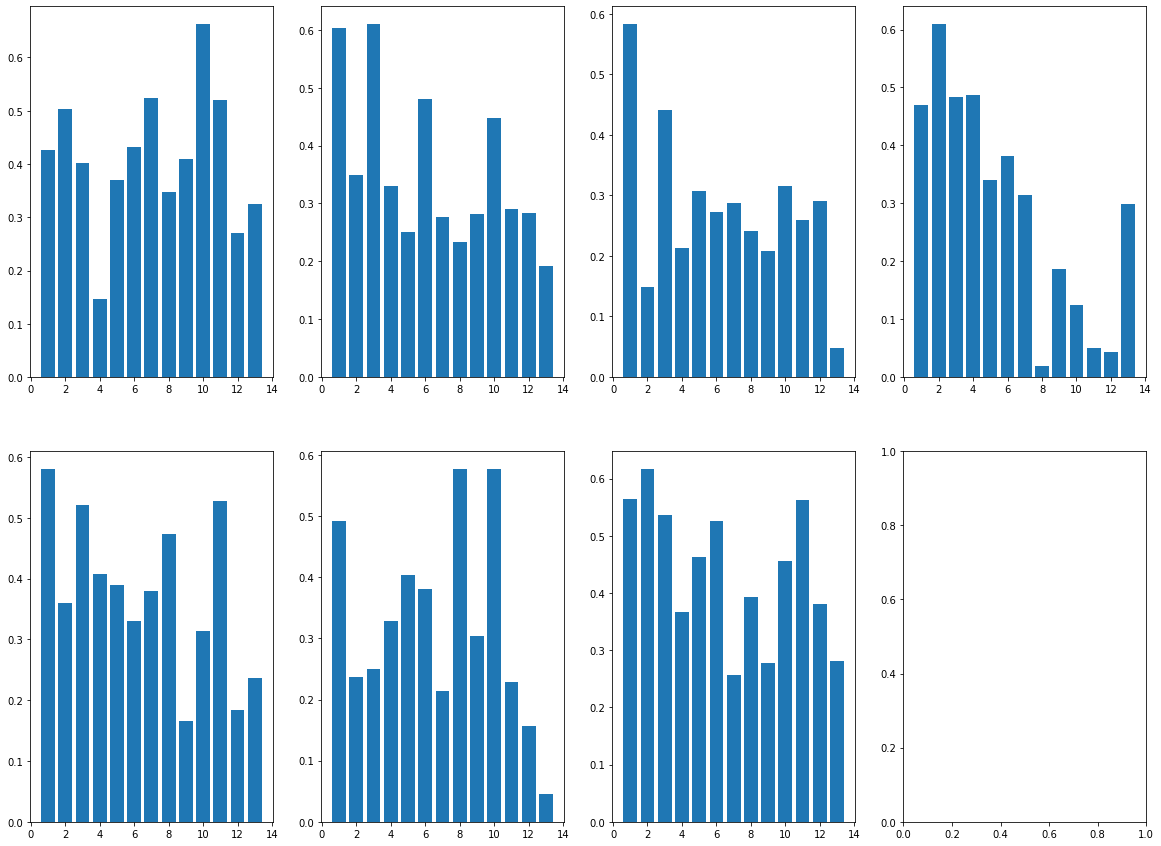

tensor(0.3533)


In [8]:
x = range(1,14,1)
model.eval()
with torch.no_grad():
    test_dice = 0
    a = 0
    
    b = 0
    fig, ax = plt.subplots(2,4,figsize=(20,15))
    fig.patch.set_facecolor('xkcd:white')
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        
        XnY = torch.ones((len(data.y))).to(device)*14
        for i in range(len(data.y)):
            if pred[i] == data.y[i]:
                XnY[i] = pred[i]
        D = torch.zeros((14))
        for j in range(14):
            if ( len(torch.where(pred==j)[0])+len(torch.where(data.y==j)[0])) == 0:
                D[j] = 0
            else:
                D[j]=((2*len(torch.where(XnY==j)[0]))/( len(torch.where(pred==j)[0])+len(torch.where(data.y==j)[0])) ) 

        dice = (torch.sum(D)-D[0])/13

        ax[a,b].bar(x,D[1:])
        test_dice += dice
        if b != 3:
            b+=1
        else:
            a+=1
            b=0
    
    plt.show()
    test_dice = test_dice/len(test_set)
print(test_dice)